In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import emcee
import corner
from scipy.optimize import minimize
from IPython.display import Math

import multiprocessing

import model_transits

In [2]:
data_arr = np.load('/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/arrays/data_arr.npy', allow_pickle=True)[1:]

# exclude 4/1/22 transit (different filter)
dates = ['2022-06-02', '2023-07-31', '2023-08-14', '2024-05-13',
         '2024-06-06', '2024-06-13', '2024-06-23', '2024-06-30', '2024-07-07',
         '2024-07-14', '2024-07-24', '2024-08-07', '2024-08-14', '2025-05-17',
         '2025-05-24', '2025-06-07', '2025-06-17', '2025-07-01', '2025-07-18']
base_dir = '/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/arrays'

for i, date in enumerate(dates):
    theta_mcmc = np.load('../arrays/theta_mcmc_{}.npy'.format(date))
    data_arr[i]['BJD_TDB'] -= theta_mcmc[0] # center midtransit on time 0

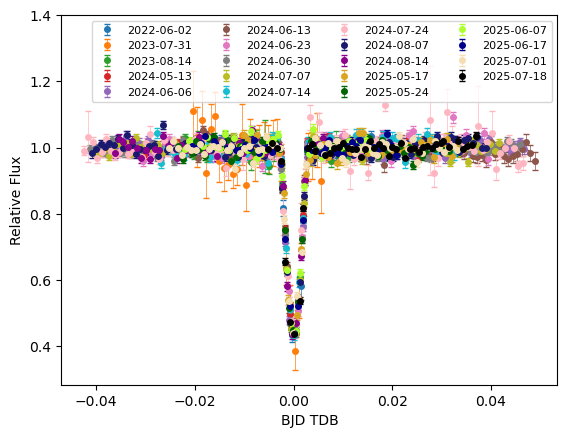

In [3]:
# plot raw data
%matplotlib inline

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
          'lightpink', 'midnightblue', 'darkmagenta', 'goldenrod', 
          'darkgreen', 'greenyellow', 'darkblue', 'wheat', 'black']

for i, color in enumerate(colors):
    plt.errorbar(data_arr[i]['BJD_TDB'], data_arr[i]['rel_flux_T1_normalized'], linestyle='none', marker='o', 
                markersize=4, yerr=data_arr[i]['rel_flux_err_T1_normalized'], elinewidth=0.5, capsize=2, color=color, label=dates[i])
plt.xlabel("BJD TDB")
plt.ylabel("Relative Flux")
plt.ylim(top=1.4)

plt.legend(loc='upper right', ncol=4, fontsize=8);

In [4]:
bjd_tdb = []
rel_flux = []
rel_flux_err = []

for i in range(len(dates)):
    bjd_tdb.extend(data_arr[i]['BJD_TDB'].to_numpy())
    rel_flux.extend(data_arr[i]['rel_flux_T1_normalized'].to_numpy())
    rel_flux_err.extend(data_arr[i]['rel_flux_err_T1_normalized'].to_numpy())

bjd_tdb = np.array(bjd_tdb)
rel_flux = np.array(rel_flux)
rel_flux_err = np.array(rel_flux_err)

indices = np.argsort(bjd_tdb)
bjd_tdb = bjd_tdb[indices]
rel_flux = rel_flux[indices]
rel_flux_err = rel_flux_err[indices]

In [5]:
df = pd.DataFrame({
    'BJD_TDB': bjd_tdb,
    'rel_flux': rel_flux,
    'rel_flux_err': rel_flux_err
})

#df.to_excel('combined_lightcurves.xlsx', index=False)

In [6]:
#df = pd.read_excel('combined_lightcurves.xlsx')

bjd_tdb = df['BJD_TDB'].values
rel_flux = df['rel_flux'].values
rel_flux_err = df['rel_flux_err'].values

In [7]:
mask = np.abs(bjd_tdb) < 0.005
bjd_tdb = bjd_tdb[mask]
rel_flux = rel_flux[mask]
rel_flux_err = rel_flux_err[mask]

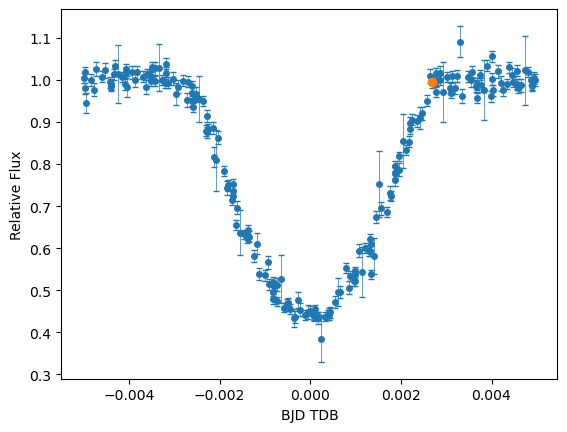

In [8]:
# plot raw data
%matplotlib inline

i = 155
plt.errorbar(bjd_tdb, rel_flux, linestyle='none', marker='o', 
             markersize=4, yerr=rel_flux_err, elinewidth=0.5, capsize=2)
plt.plot(bjd_tdb[i], rel_flux[i], 'o', markersize=6, zorder=3)
plt.xlabel("BJD TDB")
plt.ylabel("Relative Flux");

In [9]:
# number of first and last normal data points before/after transit
# and data point closest to midpoint of transit
start = 43
mid = 105
end = 155

In [10]:
median = np.median(np.concatenate((rel_flux[:start], rel_flux[end:])))
rel_flux_normalized = rel_flux / median
rel_flux_err_normalized = rel_flux_err / median

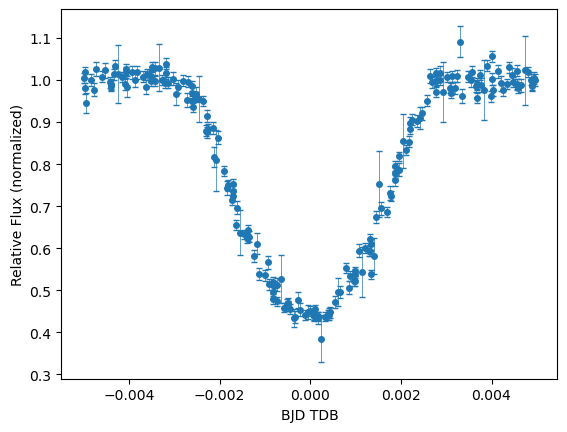

In [11]:
# plot normalized data
%matplotlib inline
plt.errorbar(bjd_tdb, rel_flux_normalized, linestyle='none', linewidth=1.5, marker='o', 
             markersize=4, yerr=rel_flux_err_normalized, elinewidth=0.5, capsize=2)
plt.xlabel("BJD TDB")
plt.ylabel("Relative Flux (normalized)");

In [12]:
period = 1.4079405 # from NASA Exoplanet Archive
times = np.arange(bjd_tdb[0], bjd_tdb[-1], 0.0001)

In [13]:
# initial guesses
t0_true = 0.0
b_true = 7.16 # from Vanderburg
r_a_true = 0.002986 # calculated as 0.01310 R✶(R⦿) x (0.00465047 au / 1 R⦿) x (1 orbital distance / 0.0204 au), both intermediate values from Vanderburg
r_a_true *= 1000 # normalization
Rp_Rs_true = 7.28 # from Vanderburg
u1_true = 0.059928009 # R filter
u2_true = 0.41764400

log_f_true = np.log(0.01)
theta_initial = np.array([t0_true, b_true, r_a_true, Rp_Rs_true, log_f_true, u1_true, u2_true]) # remove m, c

In [14]:
def plot_lightcurve(title, theta=None):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    title_size = 20
    fontsize = 15

    ax.errorbar(bjd_tdb, rel_flux, linewidth=1.5,
                linestyle='solid', marker='o', markersize=4, elinewidth=0.5,
                yerr=rel_flux_err, capsize=2, color='crimson')
    ax.set_title(title, fontsize=title_size, y=1.01)

    if theta is not None:
        t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta
        model = model_transits.modeltransit([t0, b, r_a/1000, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, times)
        plt.plot(times, model, markersize=3, color='black', zorder=3)

    ax.set_ylabel('Relative Flux', fontsize=fontsize)
    ax.set_xlabel('BJD TDB', fontsize=fontsize)

/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


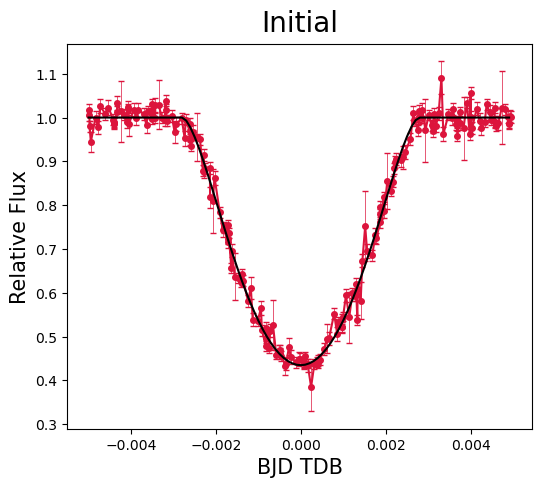

In [15]:
plot_lightcurve('Initial', theta=theta_initial)

/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


Maximum likelihood estimates:
t0 = -0.00000
b = 7.71173
r_a = 21.61381
Rp_Rs = 2467.29721
f = 0.01742
u1 = 0.39646
u2 = 1.00880


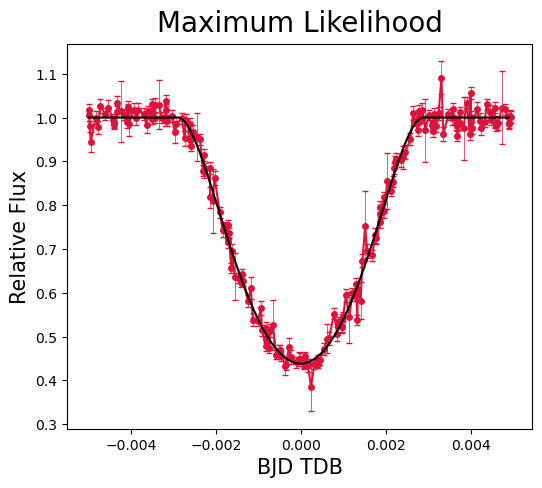

In [16]:
# likelihood function for Gaussian distribution with variance underestimated by fractional amount f (https://emcee.readthedocs.io/en/stable/tutorials/line/)
def log_likelihood(theta, x, y, yerr): # x = time, y = rel_flux
    t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta
    model = model_transits.modeltransit([t0,b,r_a/1000,Rp_Rs,1,u1,u2],model_transits.occultquad,period,x)
    sigma2 = yerr**2 + model**2 * np.exp(2*log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# negative log likelihood function
nll = lambda *args: -log_likelihood(*args)

soln = minimize(nll, theta_initial, args=(bjd_tdb, rel_flux_normalized, rel_flux_err_normalized))

theta_ml = soln.x
t0_ml, b_ml, r_a_ml, Rp_Rs_ml, log_f_ml, u1_ml, u2_ml = theta_ml

print("Maximum likelihood estimates:")
print("t0 = {0:.5f}".format(t0_ml))
print("b = {0:.5f}".format(b_ml))
print("r_a = {0:.5f}".format(np.exp(r_a_ml)))
print("Rp_Rs = {0:.5f}".format(np.exp(Rp_Rs_ml)))
print("f = {0:.5f}".format(np.exp(log_f_ml)))
print("u1 = {0:.5f}".format(u1_ml))
print("u2 = {0:.5f}".format(u2_ml))

plot_lightcurve('Maximum Likelihood', theta=theta_ml)

In [17]:
# uniform priors on all parameters
def log_prior(theta):
    t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta
    #if (bjd_tdb[start] < t0 < bjd_tdb[end] and 0.15 < b < 14.15 and 0 < r_a < 0.006*1000 
    #    and 2.3 < Rp_Rs < 12.3 and -10 < log_f < 10 and 0.0 < u1 < 1.0 and 0.0 < u2 < 1.0): #0.48 < u1 < 0.68 and 0.04 < u2 < 0.24): 
    if  (-0.0005 < t0 < 0.0005 and 5.0 < b < 9.5 and 0.002*1000 < r_a < 0.004*1000 
        and 5 < Rp_Rs < 12 and -10 < log_f < -3 and 0.0 < u1 < 1.0 and 0.0 < u2 < 1.0):
        return 0.0
    return -np.inf

In [18]:
def log_probability(theta, x, y, yerr): # x = time, y = flux
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [19]:
# initialize walkers in tiny Gaussian ball around ML soln
pos = soln.x + np.array([0.0001, 0.3, 0.0002*1000, 0.3, 1, 0.05, 0.05]) * np.random.randn(256, 7) # 256 walkers, 7 dimensions
nwalkers, ndim = pos.shape

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
#                                args=(bjd_tdb,rel_flux_normalized,
#                                      rel_flux_err_normalized))

#sampler.run_mcmc(pos, 5_000, progress=True);

ctx = multiprocessing.get_context("fork")
with ctx.Pool(processes=multiprocessing.cpu_count()) as pool:
      sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(bjd_tdb, rel_flux_normalized, rel_flux_err_normalized), pool=pool)
      sampler.run_mcmc(pos, 50_000, progress=True)

  0%|          | 0/50000 [00:00<?, ?it/s]/Users/eligendreaudistler/anaconda3/envs/wd1856_env2/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [09:17<00:00, 89.71it/s]


In [20]:
# check mean acceptance fraction and autocorrelation time
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
try:
    print("Autocorr time (per param):", sampler.get_autocorr_time())
except Exception as e:
    print("Autocorr time not estimated yet:", e)

Mean acceptance fraction: 0.2889203125
Autocorr time (per param): [212.14261079 566.78790108 576.19576212 560.37506662 210.22648991
 298.03143381 270.21654232]


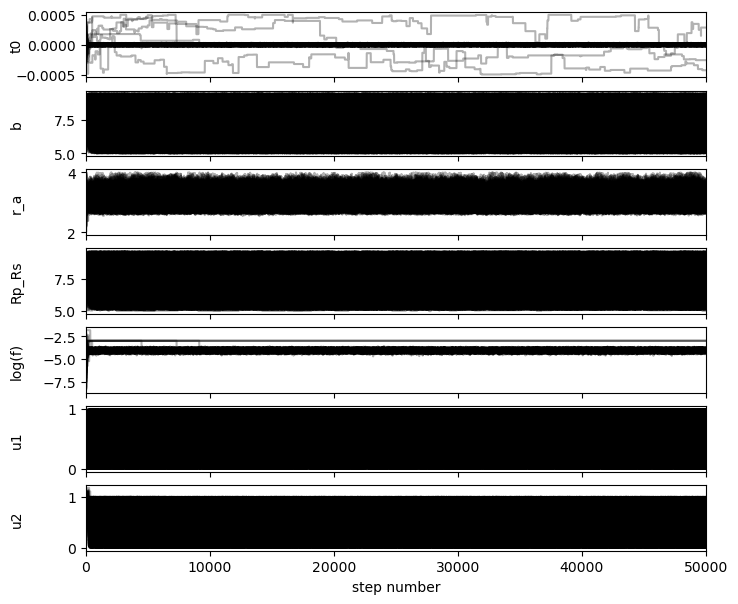

In [21]:
fig, axes = plt.subplots(7, figsize=(8,7), sharex=True)
samples = sampler.get_chain()
labels = ["t0","b","r_a","Rp_Rs","log(f)","u1","u2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i],"k",alpha=0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
    
axes[-1].set_xlabel("step number");

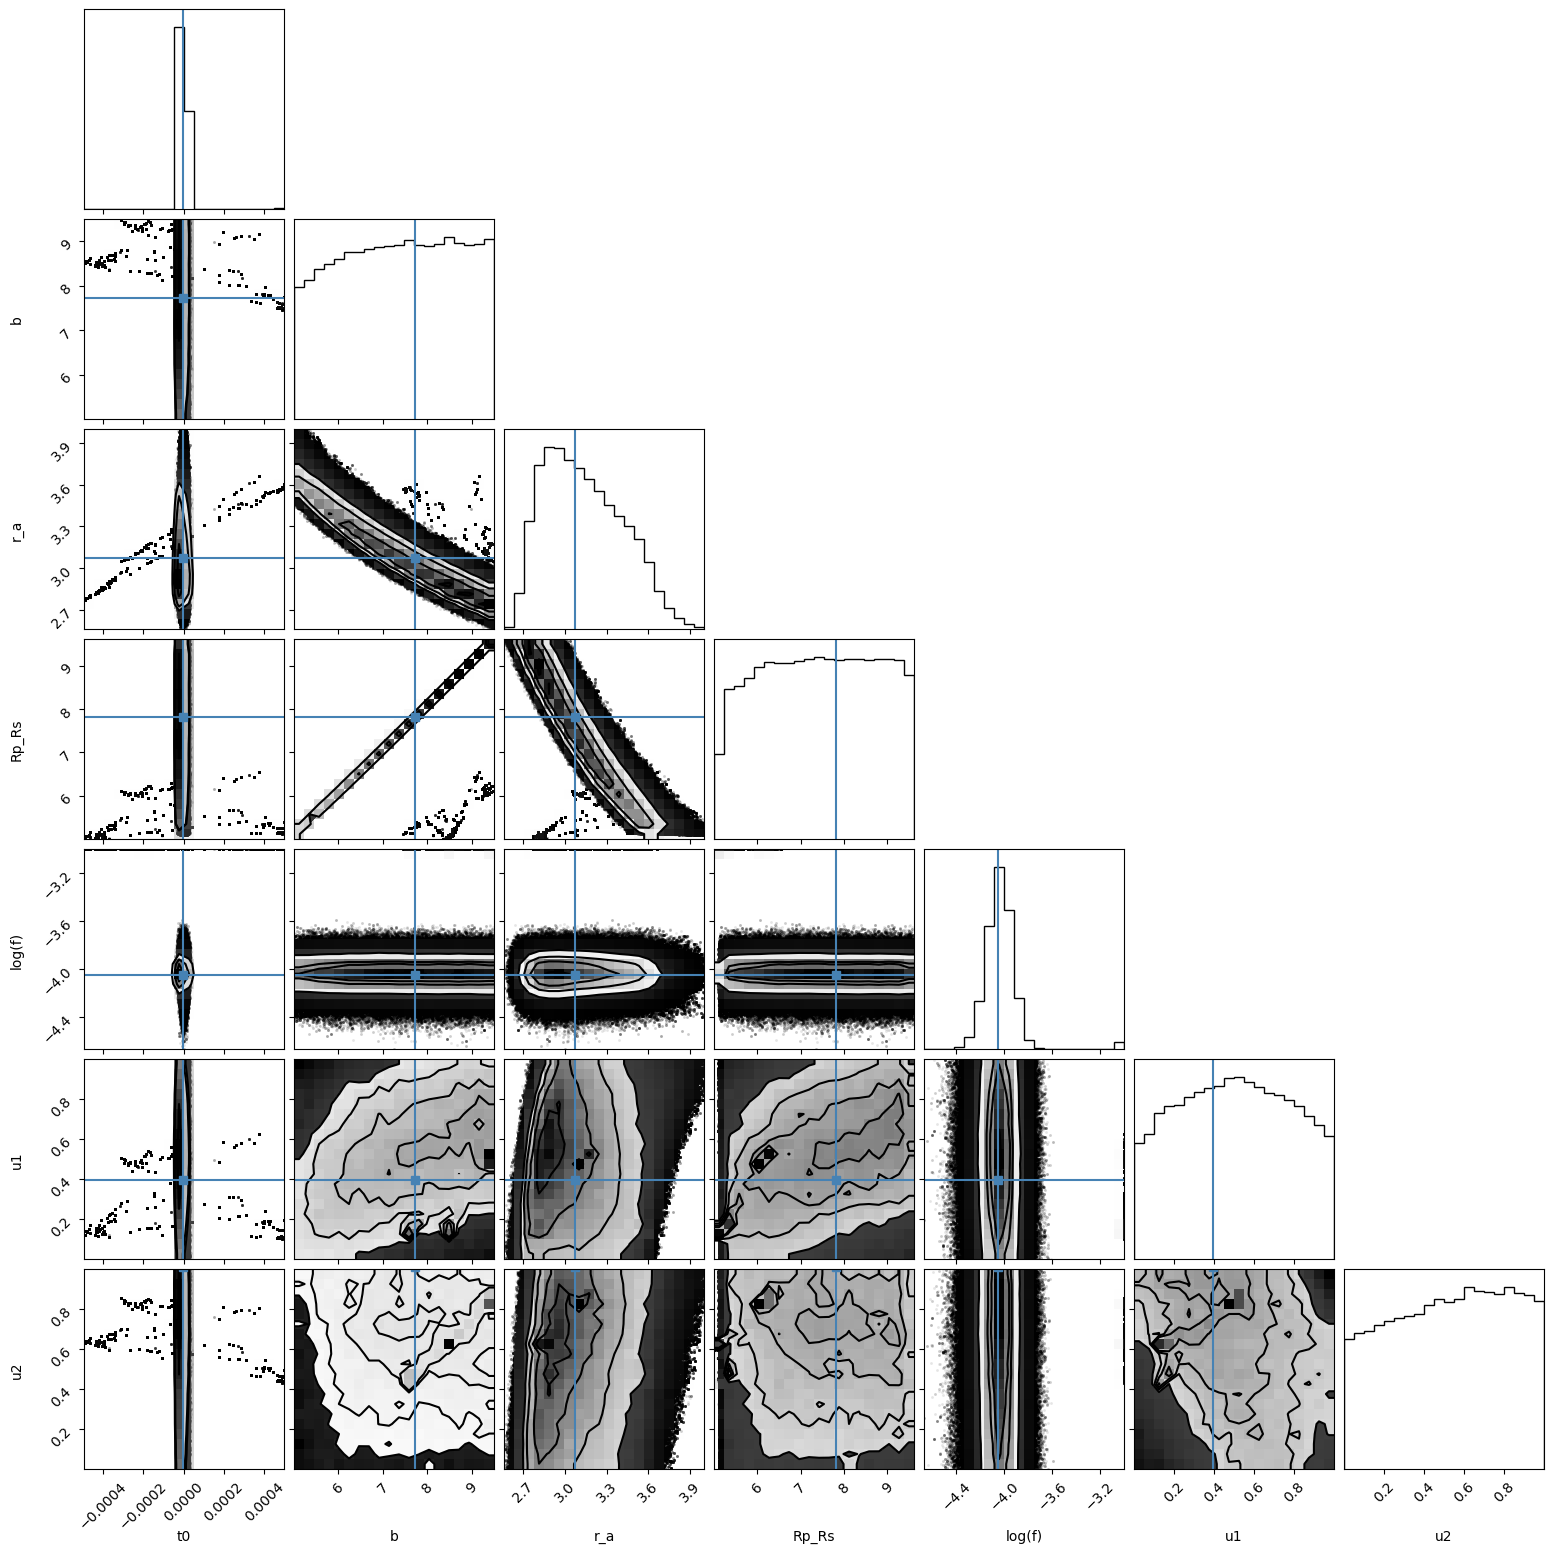

In [22]:
flat_samples = sampler.get_chain(discard=25_000, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths = [t0_ml, b_ml, r_a_ml, Rp_Rs_ml, log_f_ml, u1_ml, u2_ml]
);

In [23]:
# compute parameters to cite
# here use 16th, 50th, and 84th percentiles
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[-1.57042003e-06  7.36402193e+00  3.10548776e+00  7.41714825e+00
 -4.03743644e+00  5.03473967e-01  5.38905203e-01]


/Users/eligendreaudistler/Desktop/Berkeley_S26/wd-1856-534b/fit_lightcurves/model_transits.py:852: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


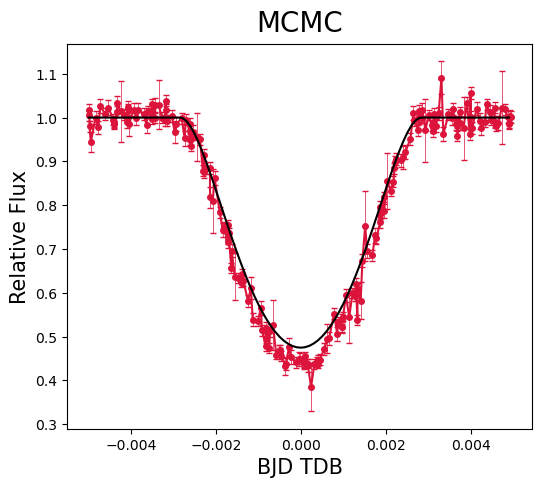

In [24]:
theta_mcmc = []
for j in np.arange(ndim):
    i = np.median(flat_samples[:, j])
    theta_mcmc = np.append(theta_mcmc,i)

print(theta_mcmc)

plot_lightcurve('MCMC', theta=theta_mcmc)

In [25]:
t0, b, r_a, Rp_Rs, log_f, u1, u2 = theta_mcmc
detrend = rel_flux_normalized
model = model_transits.modeltransit([t0, b, r_a/1000, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, bjd_tdb);
res = detrend - model

Text(0.5, 0.98, 'WD 1856+534 b')

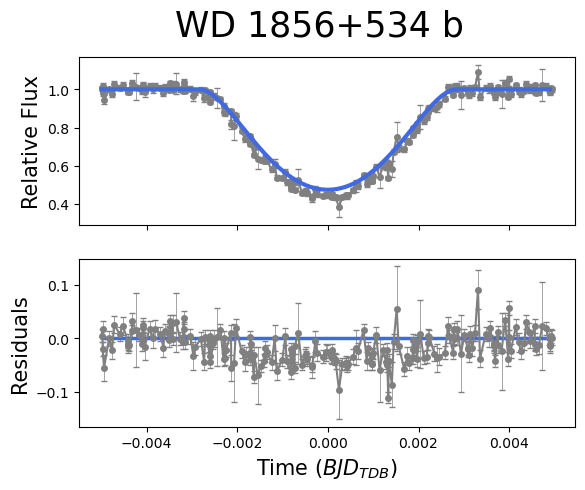

In [26]:
model_times = model_transits.modeltransit([t0, b, r_a/1000, Rp_Rs, 1, u1, u2], model_transits.occultquad, period, times)

fig, ax = plt.subplots(2,sharex=True)

ax[0].errorbar(bjd_tdb, detrend, yerr=rel_flux_err, linestyle='solid', linewidth=1.5, marker='o', 
               markersize=4, elinewidth=0.5, capsize=2, color='grey')
ax[0].plot(times, model_times, color='royalblue', linewidth=3, zorder=3)

ax[1].errorbar(bjd_tdb, res, yerr=rel_flux_err, linestyle='solid', linewidth=1.5, marker='o', 
               markersize=4, elinewidth=0.5, capsize=2, color='grey')
ax[1].plot([bjd_tdb[0], bjd_tdb[-1]], [0, 0], color='royalblue', linewidth=2.5)

plt.xlabel("Time $(BJD_{TDB})$", fontsize=15)
ax[0].set_ylabel("Relative Flux", fontsize=15)
ax[1].set_ylabel("Residuals", fontsize=15)
fig.suptitle('WD 1856+534 b', fontsize=25)

In [27]:
arr_dir = '/Users/eligendreaudistler/Desktop/wd-1856-534b/arrays'
#np.save(os.path.join(arr_dir, 'theta_mcmc_combined.npy'), theta_mcmc)

In [28]:
print(theta_mcmc)

[-1.57042003e-06  7.36402193e+00  3.10548776e+00  7.41714825e+00
 -4.03743644e+00  5.03473967e-01  5.38905203e-01]
